In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
import string
import re

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [9]:
data = pd.read_csv("C:/Users/adhit/Desktop/Lush/LUSH/reviews.csv")
data.head()

,Review,Rating
0,Went to the one in Leeds city centre and there...,5
1,The employees in the tunbridge wells branch we...,5
2,Near death experience nearly had an asthma attack,2
3,The lady helped me get 2 bathbombs for my frie...,5
4,I visited the Chelmsford branch and had a conv...,5


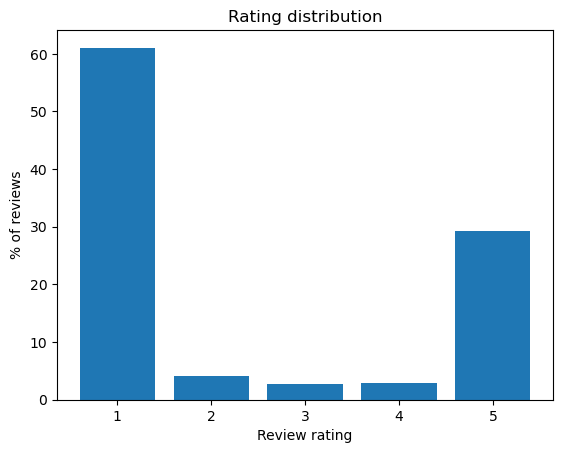

In [10]:
values, counts = np.unique(data['Rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(values, normalized_counts * 100)
plt.xlabel('Review rating')
plt.ylabel('% of reviews')
plt.title("Rating distribution")
plt.show()

In [11]:
simple_data = data.copy()
simple_data.head()

,Review,Rating
0,Went to the one in Leeds city centre and there...,5
1,The employees in the tunbridge wells branch we...,5
2,Near death experience nearly had an asthma attack,2
3,The lady helped me get 2 bathbombs for my frie...,5
4,I visited the Chelmsford branch and had a conv...,5


In [12]:
simple_data['Rating'] = np.where(simple_data['Rating'] >= 3, 1, 0)
simple_data.head()

,Review,Rating
0,Went to the one in Leeds city centre and there...,1
1,The employees in the tunbridge wells branch we...,1
2,Near death experience nearly had an asthma attack,0
3,The lady helped me get 2 bathbombs for my frie...,1
4,I visited the Chelmsford branch and had a conv...,1


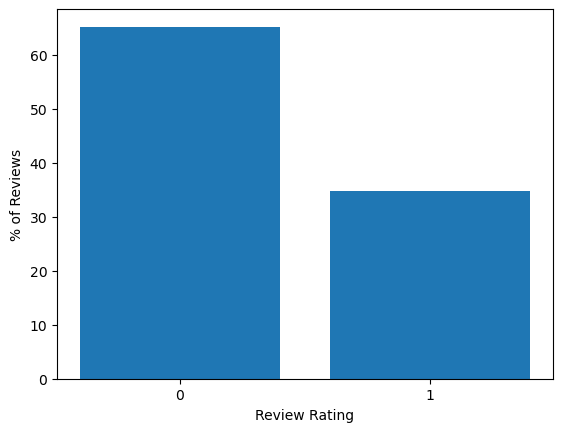

Class imbalance: [0.65 0.35]


In [13]:
values, counts = np.unique(simple_data['Rating'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Review Rating')
plt.ylabel('% of Reviews')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

### Bag-of-Words on the Reviews Data

In [14]:
# store simplified data in X and y
X = simple_data['Review']
y = simple_data['Rating']

In [15]:
# splitting our data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
X_train.shape

(1154,)

In [19]:
X_test.shape

(569,)

In [20]:
# Combine X_train and y_train into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
class_0 = train_data[train_data['Rating'] == 0]
class_1 = train_data[train_data['Rating'] == 1]

# Determine the size of the desired balanced dataset
target_size = len(class_0)

# Upsample the minority class by randomly duplicating samples
class_1_upsampled = class_1.sample(n=target_size, replace=True, random_state=42)

# Combine the upsampled minority class with the majority class
balanced_train_data = pd.concat([class_0, class_1_upsampled])

# Shuffle the balanced dataset
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42)

# Separate X and y from the balanced dataset
X_train_resampled = balanced_train_data['Review']
y_train_resampled = balanced_train_data['Rating']

In [21]:
X_train_resampled.shape

(1490,)

In [24]:
y_train_resampled[y_train_resampled == 0].shape

(745,)

## custom tokenizer

In [29]:
stemmer = nltk.stem.PorterStemmer()

# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

def remove_html_tags(text):
    pattern = re.compile(r'<.*?>')  
    return pattern.sub('', text)


def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()
        
    # remove digits using list comprehension
    sentence = ''.join([char for char in sentence if not char.isdigit()])
    
    # remove html tags
    sentence = remove_html_tags(sentence)

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adhit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
from sklearn.feature_extraction.text import CountVectorizer

bagofwords = CountVectorizer(min_df=5, 
                             tokenizer=my_tokenizer, ngram_range=(1,2))
bagofwords.fit(X_train_resampled)

X_train_transformed = bagofwords.transform(X_train_resampled)
X_test_transformed = bagofwords.transform(X_test)

In [35]:
# Fitting a model
logreg = LogisticRegression()
logreg.fit(X_train_transformed, y_train_resampled)

LogisticRegression()

In [36]:
# Make predictions on the test data
y_pred = logreg.predict(X_test_transformed)

In [37]:
# Training and test score
print(f"Train score: {logreg.score(X_train_transformed, y_train_resampled)}")
print(f"Test score: {logreg.score(X_test_transformed, y_test)}")

Train score: 0.9986577181208054
Test score: 0.9226713532513181


In [40]:
# Example review
example_review = "I ordered 2 items (2 face masks) but only one arrived.Sent an email to Customer Services and never got a reply. Really bad service ðŸ‘ŽðŸ¼"

# # Preprocess the example review using the tokenizer function
processed_example = my_tokenizer(example_review)

# Transform the processed example review using the same CountVectorizer instance
example_transformed = bagofwords.transform([' '.join(processed_example)])

# Make prediction using the trained logistic regression model
prediction = logreg.predict(example_transformed)

# Print the prediction
print(f"Predicted Rating for Example Review: {prediction[0]}")


Predicted Rating for Example Review: 0


In [43]:
# Example review
example_review = "Went to the one in Leeds city centre and there was a staff member called Greta.She was a great help in helping us find the perfect soap  balm and cream for my auntie who has a skin condition.Extremely helpful and was very enthusiastic and was great to me and my cousin.She spoke to us for about 5-10 mins and not once did Greta get annoyed at any of our questions and answered them with ease.Very helpful and great staff member at the Leeds City Centre lush."

# # Preprocess the example review using the tokenizer function
processed_example = my_tokenizer(example_review)

# Transform the processed example review using the same CountVectorizer instance
example_transformed = bagofwords.transform([' '.join(processed_example)])

# Make prediction using the trained logistic regression model
prediction = logreg.predict(example_transformed)

# Print the prediction
print(f"Predicted Rating for Example Review: {prediction[0]}")


Predicted Rating for Example Review: 1


## Let's save this model

In [45]:
# importing pickle packages
import pickle
pickle.dump(logreg, open('./model.sav', 'wb'))

In [46]:
# Save the fitted CountVectorizer using pickle
vectorizer_path = './vectorizer.pkl'
with open(vectorizer_path, 'wb') as vectorizer_file:
    pickle.dump(bagofwords, vectorizer_file)